# 패키지 Import

In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from types import SimpleNamespace
from sklearn.preprocessing import MinMaxScaler
import os

import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

from blitz.modules.base_bayesian_module import BayesianModule, BayesianRNN
from blitz.modules.weight_sampler import TrainableRandomDistribution, PriorWeightDistribution
from blitz.utils import variational_estimator


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import deque

# 데이터 준비 (베이스라인)

In [4]:
config = {
    "learning_rate": 2e-5,
    "epoch": 30,
    "batch_size": 64,
    "hidden_size": 64,
    "num_layers": 2,
    "output_size": 3
}

CFG = SimpleNamespace(**config)

품목_리스트 = ['건고추', '사과', '감자', '배', '깐마늘(국산)', '무', '상추', '배추', '양파', '대파']

In [5]:
def process_data(raw_file, 산지공판장_file, 전국도매_file, 품목명, scaler=None):
    raw_data = pd.read_csv(raw_file)
    산지공판장 = pd.read_csv(산지공판장_file)
    전국도매 = pd.read_csv(전국도매_file)

    # 타겟 및 메타데이터 필터 조건 정의
    conditions = {
    '감자': {
        'target': lambda df: (df['품종명'] == '감자 수미') & (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['감자'], '품종명': ['수미'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['감자'], '품종명': ['수미']}
    },
    '건고추': {
        'target': lambda df: (df['품종명'] == '화건') & (df['거래단위'] == '30 kg') & (df['등급'] == '상품'),
        '공판장': None, 
        '도매': None  
    },
    '깐마늘(국산)': {
        'target': lambda df: (df['거래단위'] == '20 kg') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['마늘'], '품종명': ['깐마늘'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['마늘'], '품종명': ['깐마늘']}
    },
    '대파': {
        'target': lambda df: (df['품종명'] == '대파(일반)') & (df['거래단위'] == '1키로단') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['대파'], '품종명': ['대파(일반)'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['대파'], '품종명': ['대파(일반)']}
    },
    '무': {
        'target': lambda df: (df['거래단위'] == '20키로상자') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['무'], '품종명': ['기타무'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['무'], '품종명': ['무']}
    },
    '배추': {
        'target': lambda df: (df['거래단위'] == '10키로망대') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배추'], '품종명': ['쌈배추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배추'], '품종명': ['배추']}
    },
    '사과': {
        'target': lambda df: (df['품종명'].isin(['홍로', '후지'])) & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['사과'], '품종명': ['후지'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['사과'], '품종명': ['후지']}
    },
    '상추': {
        'target': lambda df: (df['품종명'] == '청') & (df['거래단위'] == '100 g') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['상추'], '품종명': ['청상추'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['상추'], '품종명': ['청상추']}
    },
    '양파': {
        'target': lambda df: (df['품종명'] == '양파') & (df['거래단위'] == '1키로') & (df['등급'] == '상'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['양파'], '품종명': ['기타양파'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['양파'], '품종명': ['양파(일반)']}
    },
    '배': {
        'target': lambda df: (df['품종명'] == '신고') & (df['거래단위'] == '10 개') & (df['등급'] == '상품'),
        '공판장': {'공판장명': ['*전국농협공판장'], '품목명': ['배'], '품종명': ['신고'], '등급명': ['상']},
        '도매': {'시장명': ['*전국도매시장'], '품목명': ['배'], '품종명': ['신고']}
    }
    }

    # 타겟 데이터 필터링
    raw_품목 = raw_data[raw_data['품목명'] == 품목명]
    target_mask = conditions[품목명]['target'](raw_품목)
    filtered_data = raw_품목[target_mask]

    # 다른 품종에 대한 파생변수 생성
    other_data = raw_품목[~target_mask]
    unique_combinations = other_data[['품종명', '거래단위', '등급']].drop_duplicates()
    for _, row in unique_combinations.iterrows():
        품종명, 거래단위, 등급 = row['품종명'], row['거래단위'], row['등급']
        mask = (other_data['품종명'] == 품종명) & (other_data['거래단위'] == 거래단위) & (other_data['등급'] == 등급)
        temp_df = other_data[mask]
        for col in ['평년 평균가격(원)', '평균가격(원)']:
            new_col_name = f'{품종명}_{거래단위}_{등급}_{col}'
            filtered_data = filtered_data.merge(temp_df[['시점', col]], on='시점', how='left', suffixes=('', f'_{new_col_name}'))
            filtered_data.rename(columns={f'{col}_{new_col_name}': new_col_name}, inplace=True)


    # 공판장 데이터 처리
    if conditions[품목명]['공판장']:
        filtered_공판장 = 산지공판장
        for key, value in conditions[품목명]['공판장'].items():
            filtered_공판장 = filtered_공판장[filtered_공판장[key].isin(value)]
        
        filtered_공판장 = filtered_공판장.add_prefix('공판장_').rename(columns={'공판장_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_공판장, on='시점', how='left')

    # 도매 데이터 처리
    if conditions[품목명]['도매']:
        filtered_도매 = 전국도매
        for key, value in conditions[품목명]['도매'].items():
            filtered_도매 = filtered_도매[filtered_도매[key].isin(value)]
        
        filtered_도매 = filtered_도매.add_prefix('도매_').rename(columns={'도매_시점': '시점'})
        filtered_data = filtered_data.merge(filtered_도매, on='시점', how='left')

    # 수치형 컬럼 처리
    numeric_columns = filtered_data.select_dtypes(include=[np.number]).columns
    filtered_data = filtered_data[['시점'] + list(numeric_columns)]
    filtered_data[numeric_columns] = filtered_data[numeric_columns].fillna(0)

    # # 정규화 적용
    # if scaler is None:
    #     scaler = MinMaxScaler()
    #     filtered_data[numeric_columns] = scaler.fit_transform(filtered_data[numeric_columns])
    # else:
    #     filtered_data[numeric_columns] = scaler.transform(filtered_data[numeric_columns])

    return filtered_data


# 베이지안 LSTM 구현

In [7]:
# 베이지안 LSTM (From blitz)

class BayesianLSTM(BayesianRNN):
    """
    Bayesian LSTM layer, implements the linear layer proposed on Weight Uncertainity on Neural Networks
    (Bayes by Backprop paper).

    Its objective is be interactable with torch nn.Module API, being able even to be chained in nn.Sequential models with other non-this-lib layers
    
    parameters:
        in_features: 입력 특성의 수 (정수)
        out_features: 출력 특성의 수 (정수)
        bias: 편향 항 사용 여부 (불리언)
        prior_sigma_1: 혼합 사전 분포 1의 표준편차 (실수)
        prior_sigma_2: 혼합 사전 분포 2의 표준편차 (실수)
        prior_pi: 스케일된 혼합 사전 분포의 pi 값 (실수)
        posterior_mu_init: 가중치 mu 초기화를 위한 사후 평균 (실수)
        posterior_rho_init: 가중치 rho 초기화를 위한 사후 평균 (실수)
        freeze: 가중치를 고정된(결정론적) 상태로 시작할지 여부 (불리언)
    
    """
    def __init__(self,
                 in_features,
                 out_features,
                 bias = True,
                 prior_sigma_1 = 0.1,
                 prior_sigma_2 = 0.002,
                 prior_pi = 1,
                 posterior_mu_init = 0,
                 posterior_rho_init = -6.0,
                 freeze = False,
                 prior_dist = None,
                 peephole = False,
                 **kwargs):
        
        super().__init__(**kwargs)
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias
        self.freeze = freeze
        self.peephole = peephole
        
        self.posterior_mu_init = posterior_mu_init
        self.posterior_rho_init = posterior_rho_init
        
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi = prior_pi
        self.prior_dist = prior_dist
        
        # Variational weight parameters and sample for weight ih
        self.weight_ih_mu = nn.Parameter(torch.Tensor(in_features, out_features * 4).normal_(posterior_mu_init, 0.1))
        self.weight_ih_rho = nn.Parameter(torch.Tensor(in_features, out_features * 4).normal_(posterior_rho_init, 0.1))
        self.weight_ih_sampler = TrainableRandomDistribution(self.weight_ih_mu, self.weight_ih_rho)
        self.weight_ih = None
        
        # Variational weight parameters and sample for weight hh
        self.weight_hh_mu = nn.Parameter(torch.Tensor(out_features, out_features * 4).normal_(posterior_mu_init, 0.1))
        self.weight_hh_rho = nn.Parameter(torch.Tensor(out_features, out_features * 4).normal_(posterior_rho_init, 0.1))
        self.weight_hh_sampler = TrainableRandomDistribution(self.weight_hh_mu, self.weight_hh_rho)
        self.weight_hh = None
        
        # Variational weight parameters and sample for bias
        self.bias_mu = nn.Parameter(torch.Tensor(out_features * 4).normal_(posterior_mu_init, 0.1))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features * 4).normal_(posterior_rho_init, 0.1))
        self.bias_sampler = TrainableRandomDistribution(self.bias_mu, self.bias_rho)
        self.bias=None
        
        #our prior distributions
        self.weight_ih_prior_dist = PriorWeightDistribution(self.prior_pi, self.prior_sigma_1, self.prior_sigma_2, dist = self.prior_dist)
        self.weight_hh_prior_dist = PriorWeightDistribution(self.prior_pi, self.prior_sigma_1, self.prior_sigma_2, dist = self.prior_dist)
        self.bias_prior_dist = PriorWeightDistribution(self.prior_pi, self.prior_sigma_1, self.prior_sigma_2, dist = self.prior_dist)
        
        self.init_sharpen_parameters()
        
        self.log_prior = 0
        self.log_variational_posterior = 0
    
    
    def sample_weights(self):
        #sample weights
        weight_ih = self.weight_ih_sampler.sample()
        weight_hh = self.weight_hh_sampler.sample()
        
        #if use bias, we sample it, otherwise, we are using zeros
        if self.use_bias:
            b = self.bias_sampler.sample()
            b_log_posterior = self.bias_sampler.log_posterior()
            b_log_prior = self.bias_prior_dist.log_prior(b)
            
        else:
            b = None
            b_log_posterior = 0
            b_log_prior = 0
            
        bias = b
        
        #gather weights variational posterior and prior likelihoods
        self.log_variational_posterior = self.weight_hh_sampler.log_posterior() + b_log_posterior + self.weight_ih_sampler.log_posterior()
        
        self.log_prior = self.weight_ih_prior_dist.log_prior(weight_ih) + b_log_prior + self.weight_hh_prior_dist.log_prior(weight_hh)
        
        
        self.ff_parameters = [weight_ih, weight_hh, bias]
        return weight_ih, weight_hh, bias
        
    def get_frozen_weights(self):
        
        #get all deterministic weights
        weight_ih = self.weight_ih_mu
        weight_hh = self.weight_hh_mu
        if self.use_bias:
            bias = self.bias_mu
        else:
            bias = 0

        return weight_ih, weight_hh, bias

    
    def forward_(self,
                 x,
                 hidden_states,
                 sharpen_loss):
        
        if self.loss_to_sharpen is not None:
            sharpen_loss = self.loss_to_sharpen
            weight_ih, weight_hh, bias = self.sharpen_posterior(loss=sharpen_loss, input_shape=x.shape)
        elif (sharpen_loss is not None):
            sharpen_loss = sharpen_loss
            weight_ih, weight_hh, bias = self.sharpen_posterior(loss=sharpen_loss, input_shape=x.shape)
        
        else:
            weight_ih, weight_hh, bias = self.sample_weights()

        #Assumes x is of shape (batch, sequence, feature)
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        #if no hidden state, we are using zeros
        if hidden_states is None:
            h_t, c_t = (torch.zeros(bs, self.out_features).to(x.device), 
                        torch.zeros(bs, self.out_features).to(x.device))
        else:
            h_t, c_t = hidden_states
        
        #simplifying our out features, and hidden seq list
        HS = self.out_features
        hidden_seq = []
        
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            
            if self.peephole:
                gates = x_t @ weight_ih + c_t @ weight_hh + bias
            else:
                gates = x_t @ weight_ih + h_t @ weight_hh + bias
                g_t = torch.tanh(gates[:, HS*2:HS*3])
            
            i_t, f_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            
            if self.peephole:
                c_t = f_t * c_t + i_t * torch.sigmoid(x_t @ weight_ih + bias)[:, HS*2:HS*3]
                h_t = torch.tanh(o_t * c_t)
            else:
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                
            hidden_seq.append(h_t.unsqueeze(0))
            
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        
        return hidden_seq, (h_t, c_t)

    def forward_frozen(self,
                       x,
                       hidden_states):

        weight_ih, weight_hh, bias = self.get_frozen_weights()

        #Assumes x is of shape (batch, sequence, feature)
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        #if no hidden state, we are using zeros
        if hidden_states is None:
            h_t, c_t = (torch.zeros(bs, self.out_features).to(x.device), 
                        torch.zeros(bs, self.out_features).to(x.device))
        else:
            h_t, c_t = hidden_states
        
        #simplifying our out features, and hidden seq list
        HS = self.out_features
        hidden_seq = []
        
        for t in range(seq_sz):
            x_t = x[:, t, :]
            # batch the computations into a single matrix multiplication
            
            if self.peephole:
                gates = x_t @ weight_ih + c_t @ weight_hh + bias
            else:
                gates = x_t @ weight_ih + h_t @ weight_hh + bias
                g_t = torch.tanh(gates[:, HS*2:HS*3])
            
            i_t, f_t, o_t = (
                torch.sigmoid(gates[:, :HS]), # input
                torch.sigmoid(gates[:, HS:HS*2]), # forget
                torch.sigmoid(gates[:, HS*3:]), # output
            )
            
            if self.peephole:
                c_t = f_t * c_t + i_t * torch.sigmoid(x_t @ weight_ih + bias)[:, HS*2:HS*3]
                h_t = torch.sigmoid(o_t * c_t)
            else:
                c_t = f_t * c_t + i_t * g_t
                h_t = o_t * torch.tanh(c_t)
                
            hidden_seq.append(h_t.unsqueeze(0))
            
        hidden_seq = torch.cat(hidden_seq, dim=0)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        
        return hidden_seq, (h_t, c_t)

    def forward(self,
                x,
                hidden_states=None,
                sharpen_loss=None):

        if self.freeze:
            return self.forward_frozen(x, hidden_states)
        
        if not self.sharpen:
            sharpen_posterior = False
            
        return self.forward_(x, hidden_states, sharpen_loss)   

# 모델 돌리기

## 01. 데이터 필터링

In [10]:
train_건고추 = process_data("../data/train/train.csv", 
                         "../data/train/meta/TRAIN_산지공판장_2018-2021.csv", 
                         "../data/train/meta/TRAIN_전국도매_2018-2021.csv", 
                         '건고추')
train_건고추

,시점,평년 평균가격(원),평균가격(원),햇산양건_30 kg_상품_평년 평균가격(원),햇산양건_30 kg_상품_평균가격(원),햇산화건_30 kg_중품_평년 평균가격(원),햇산화건_30 kg_중품_평균가격(원),햇산화건_30 kg_상품_평년 평균가격(원),햇산화건_30 kg_상품_평균가격(원),양건_30 kg_중품_평년 평균가격(원),양건_30 kg_중품_평균가격(원),양건_30 kg_상품_평년 평균가격(원),양건_30 kg_상품_평균가격(원),화건_30 kg_중품_평년 평균가격(원),화건_30 kg_중품_평균가격(원),햇산양건_30 kg_중품_평년 평균가격(원),햇산양건_30 kg_중품_평균가격(원)
0,201801상순,381666.666667,590000.0,0.0,0.0,0.0,0.0,0.0,0.0,415476.333333,670000.0,465476.333333,715000.0,338333.333333,545000.0,0.0,0.0
1,201801중순,380809.666667,590000.0,0.0,0.0,0.0,0.0,0.0,0.0,415166.666667,670000.0,465250.000000,715000.0,337393.000000,545000.0,0.0,0.0
2,201801하순,380000.000000,590000.0,0.0,0.0,0.0,0.0,0.0,0.0,414333.333333,670000.0,464666.666667,715000.0,336333.333333,545000.0,0.0,0.0
3,201802상순,380000.000000,590000.0,0.0,0.0,0.0,0.0,0.0,0.0,414333.333333,670000.0,464666.666667,715000.0,336333.333333,545000.0,0.0,0.0
4,201802중순,376666.666667,590000.0,0.0,0.0,0.0,0.0,0.0,0.0,412666.666667,670000.0,463000.000000,715000.0,333000.000000,545000.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,202111중순,552944.333333,558000.0,0.0,0.0,0.0,0.0,0.0,0.0,622811.000000,648400.0,672477.666667,705000.0,501477.666667,494800.0,0.0,0.0
140,202111하순,554071.333333,565143.0,0.0,0.0,0.0,0.0,0.0,0.0,623127.333333,648400.0,673152.333333,705000.0,502271.333333,500514.0,0.0,0.0
141,202112상순,559000.000000,570500.0,0.0,0.0,0.0,0.0,0.0,0.0,623333.333333,648400.0,675866.666667,705000.0,504866.666667,504800.0,0.0,0.0
142,202112중순,552000.000000,570500.0,0.0,0.0,0.0,0.0,0.0,0.0,615916.666667,648400.0,668450.000000,705000.0,497866.666667,504800.0,0.0,0.0


In [11]:
prices = train_건고추["평균가격(원)"]
scaler = MinMaxScaler()

prices_arr = np.array(prices).reshape(-1, 1)
prices = scaler.fit_transform(prices_arr)

prices_unscaled = train_건고추["평균가격(원)"]

In [12]:
window_size = 12

def create_timestamps_ds(series, 
                         timestep_size=window_size):
    time_stamps = []
    labels = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)-1):
        aux_deque.append(series[i])
        time_stamps.append(list(aux_deque))
    
    #feed the labels lsit
    for i in range(len(series)-1):
        labels.append(series[i + 1])
    
    assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps[timestep_size:]).float()
    labels = torch.tensor(labels[timestep_size:]).float()
    
    return features, labels

In [13]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(1, 10, prior_sigma_1=1, prior_pi=1, posterior_rho_init=-3.0)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [14]:
Xs, ys = create_timestamps_ds(prices)
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)



ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=8, shuffle=True)

net = NN()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

C:\Users\jjw62\AppData\Local\Temp\ipykernel_23124\35546507.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  features = torch.tensor(time_stamps[timestep_size:]).float()


In [73]:
iteration = 0
for epoch in range(100):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3,
                               complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration % 250 == 0:
            net.eval()  # 평가 모드로 전환
            with torch.no_grad():
                preds_val = net(X_train)[:,0].unsqueeze(1)
                loss_val = criterion(preds_val, y_train)
            net.train()  # 다시 학습 모드로 전환
            print("Iteration: {} Val-loss: {:.4f}".format(str(iteration), loss_val))

Iteration: 250 Val-loss: 0.0118
Iteration: 500 Val-loss: 0.0191
Iteration: 750 Val-loss: 0.0204
Iteration: 1000 Val-loss: 0.0155
Iteration: 1250 Val-loss: 0.0143


In [75]:
net.eval()
with torch.no_grad():
    preds_test = net(X_test)[:,0].unsqueeze(1)
    loss_test = criterion(preds_test, y_test)
print("Final Test Loss: {:.4f}".format(loss_test))

Final Test Loss: 0.0112


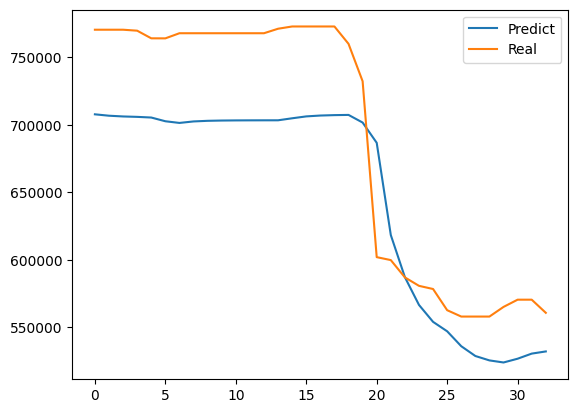

In [77]:
plt.plot(scaler.inverse_transform(preds_test), label = 'Predict')
plt.plot(scaler.inverse_transform(y_test), label='Real')
plt.legend()
plt.show()

In [19]:
def pred_price_future(X_test, future_length, sample_nbr=10):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global window_size
    global X_train
    global Xs
    global scaler
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
        as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=window_size)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [20]:
def get_confidence_intervals(preds_test, ci_multiplier):
    global scaler
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

In [21]:
future_length=8
sample_nbr=4
ci_multiplier=5
idx_pred, preds_test = pred_price_future(X_test, future_length, sample_nbr)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,
                                                                                          ci_multiplier)

In [22]:
y = np.array(train_건고추['평균가격(원)'][113:]).reshape(-1, 1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))

ValueError: operands could not be broadcast together with shapes (33,1) (31,1) 

In [ ]:
idx_pred = idx_pred + window_size + 1

In [ ]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)
plt.figure(figsize=(10,6))


plt.title("Agriculture prices", color="white")

plt.plot(df_pred.index,
         df_pred['평균가격(원)'],
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

plt.show()

In [ ]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.Close[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()